In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
location_ids = [179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 11,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

# Impact (DALYs averted)

In [3]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """
    This function pulls dalys for specified cause IDs from GBD
    -----
    INPUT (all in List() format):
    - cause
    ids for YLL models
    - nonfatal_cause_ids for YLD models
    - location_ids for which to pull dalys
    - ages (age_group_ids) for which to pull dalys
    - sexes (sex_ids) for which to pull dalys
    - index_cols with which to format output
    -----
    @returns a drawspace dataframe of DALYS attributable to each fatal or nonfatal cause_id:
        - columns = draws
        - index = multiindex(loc_id, sex_id, age_group_id, cause_id)
    """
    if len(cause_ids) + len(nonfatal_cause_ids) == 0:
        raise Exception("Must select at least one fatal or nonfatal cause_id")
        
    #init empty dfs
    ylds, ylls = pd.DataFrame(), pd.DataFrame()
    
    if len(nonfatal_cause_ids)>0:
        ylds = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='como',
            measure_id=3,
            metric_id=3,  # only available as rate
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='best',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id'])
        ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])

        #convert rate to count
        pop = get_population(
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            decomp_step='step4').set_index(index_cols)
        for i in list(range(0, 1000)):
            ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    else:
        print("No nonfatal ids selected; returning ylls only")
    
    if len(cause_ids)>0:
        ylls = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='codcorrect',
            measure_id=4,
            metric_id=1,
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='latest',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
        ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])
    else:
        print("No fatal ids selected; returning ylds only")
    
    return ylls + ylds

In [4]:
username = !whoami
coverage_confidence_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/data_richness_score.csv'
confidence = pd.read_csv(coverage_confidence_data_dir).replace('vitamin a','vitamin A').drop_duplicates()
confidence = confidence.loc[confidence.nutrient!='na']
confidence.head()

,location_name,vehicle,nutrient,score
0,Ethiopia,maize flour,folic acid,0.0
1,Angola,wheat flour,iron,0.0
2,Angola,wheat flour,vitamin A,0.0
3,Angola,wheat flour,zinc,0.0
4,China,oil,vitamin A,0.0


In [5]:
folic_acid = pd.read_csv('/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_wheat_flour_dalys_averted_folic_acid_04_01_2021.csv')
#folic_acid.head()

In [6]:
folic_acid_dalys = pd.DataFrame()
for vehicle in ['maize_flour','wheat_flour']:
    folic_acid_sub = pd.read_csv(f'/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_{vehicle}_dalys_averted_folic_acid_04_01_2021.csv')
    folic_acid_sub['vehicle'] = vehicle.replace('_',' ')
    folic_acid_sub['nutrient'] = 'folic acid'
    folic_acid_sub['measure'] = 'counts_averted'
    folic_acid_dalys = pd.concat([folic_acid_dalys, folic_acid_sub], ignore_index=True)
#folic_acid_dalys.head()

In [7]:
pop = (get_population(location_id=list(folic_acid_dalys.location_id.unique()),
                     year_id=2019,
                     sex_id=[1,2],
                     age_group_id=[2,3,4,5],
                     gbd_round_id=6,
                     decomp_step='step4')
       .groupby('location_id', as_index=False)
       .sum()
       .filter(['location_id','population']))
folic_acid_daly_rate = folic_acid_dalys.merge(pop, on='location_id')
for i in list(range(0,1000)):
    folic_acid_daly_rate[f'draw_{i}'] = (folic_acid_daly_rate[f'draw_{i}'] 
     / folic_acid_daly_rate['population']
     * 100_000)
folic_acid_daly_rate['measure'] = 'rates_averted'
#folic_acid_daly_rate.head()

In [8]:
folic_acid_total_dalys = pull_dalys([642], [642], location_ids,
                                                       [2,3,4,5], [1,2], ['location_id','age_group_id','sex_id'])
#folic_acid_total_dalys.head()

In [9]:
folic_acid_pif = (folic_acid_dalys.set_index(['location_id', 'year_id', 'coverage_level', 'vehicle', 'nutrient', 'measure']) 
                  / folic_acid_total_dalys.groupby('location_id').sum()
                  * 100).reset_index()
folic_acid_pif['measure'] = 'pif'
#folic_acid_pif.head()

In [10]:
folic_acid = pd.concat([folic_acid_dalys, folic_acid_daly_rate.drop(columns=['population']), folic_acid_pif], ignore_index=True, sort=True)
folic_acid.to_pickle('results_raw/folic_acid.pkl')
#folic_acid.head()

In [11]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
zinc_prev = pd.read_pickle('results_raw/zinc_deficiency_exposure.pkl')
zinc_prev['measure'] = 'deficiency_exposure'

vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin a'
vitamin_a_prev = pd.read_pickle('results_raw/vitamin_a_deficiency_exposure.pkl')
vitamin_a_prev['measure'] = 'deficiency_exposure'

iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_u5 = iron_u5.loc[iron_u5.year==2025]
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_wra.columns if 'draw' not in c])).reset_index()

results = pd.concat([folic_acid.rename(columns={'year_id':'year'}), zinc, vitamin_a, iron, vitamin_a_prev, zinc_prev], ignore_index=True, sort=True)
results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025]
results.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_998,draw_999,location_id,measure,nutrient,vehicle,year,nutrient_name,location_name,label
9,0.2,743.496800,1479.550469,1597.952786,1083.064738,488.736716,673.982572,510.457605,647.465561,1212.476363,...,1693.312600,1520.486189,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
10,0.5,1858.742000,3698.876173,3994.881966,2707.661845,1221.841789,1684.956430,1276.144012,1618.663902,3031.190907,...,4233.281499,3801.215472,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
11,0.8,2973.987200,5918.201877,6391.811146,4332.258952,1954.946863,2695.930288,2041.830419,2589.862243,4849.905452,...,6773.250399,6081.944755,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
21,0.2,1016.927577,1620.764474,2355.507146,2885.105359,897.596800,1118.381023,866.496853,757.477571,2210.746638,...,2244.898758,1551.782277,141,counts_averted,folic acid,wheat flour,2025.0,Folic acid,Egypt,Folic acid in wheat flour
22,0.5,2542.318942,4051.911185,5888.767865,7212.763397,2243.992000,2795.952558,2166.242132,1893.693927,5526.866595,...,5612.246894,3879.455694,141,counts_averted,folic acid,wheat flour,2025.0,Folic acid,Egypt,Folic acid in wheat flour


In [14]:
dalys_averted_by_location_and_nutrient = (results.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['coverage_level','year']))
dalys_averted_by_location_and_nutrient = dalys_averted_by_location_and_nutrient.groupby(['location_id','location_name','vehicle','nutrient']).sum().reset_index()
dalys_averted_by_location_and_nutrient.head()

,location_id,location_name,vehicle,nutrient,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,6,China,wheat flour,folic acid,37720.320196,23443.113663,12708.177015,16468.239192,16452.244306,23226.896137,...,31781.399290,22710.300886,42056.989946,27162.933061,14772.419963,21811.612928,14976.340599,14332.699402,21701.412790,26221.408512
1,6,China,wheat flour,iron,173288.068572,64024.859447,70042.773182,63730.915889,190740.213959,164294.951180,...,110683.824254,106061.658500,282215.457295,233003.240673,53909.293003,119562.730051,211805.145003,68389.093983,97381.933431,97177.736219
2,6,China,wheat flour,vitamin A,2885.767573,1206.964360,2214.466514,1301.976223,1916.809200,1689.861042,...,1972.244780,3080.172438,4255.409922,3832.516707,1825.399877,2336.591084,1490.359672,1971.445962,1045.455080,2107.788330
3,6,China,wheat flour,zinc,9.470231,0.000000,10.531877,36.679107,20.211663,11.411639,...,24.950723,68.615187,9.055410,33.455313,57.456283,66.279721,28.497553,9.453747,37.722112,63.266141
4,11,Indonesia,oil,vitamin A,7836.370030,5396.585131,3105.312955,4727.882661,3570.009616,3180.681198,...,3805.515716,6463.946702,13880.960510,12372.280382,5138.959082,4811.404620,4813.358950,3369.967382,3633.764523,2113.946032


In [15]:
dalys_averted_by_location_and_vehicle = (results.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['coverage_level','year']))
dalys_averted_by_location_and_vehicle = dalys_averted_by_location_and_vehicle.groupby(['location_id','location_name','vehicle']).sum().reset_index()
dalys_averted_by_location_and_vehicle.head()

,location_id,location_name,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,6,China,wheat flour,213903.626572,88674.937470,84975.948588,81537.810411,209129.479129,189223.119997,42019.084075,...,144462.419048,131920.747011,328536.912573,264032.145754,70564.569126,143777.213784,228300.342827,84702.693094,120166.523413,125570.199202
1,11,Indonesia,oil,7836.370030,5396.585131,3105.312955,4727.882661,3570.009616,3180.681198,630.287562,...,3805.515716,6463.946702,13880.960510,12372.280382,5138.959082,4811.404620,4813.358950,3369.967382,3633.764523,2113.946032
2,15,Myanmar,oil,82.569191,143.636143,193.968330,119.964953,75.696179,203.163625,51.205295,...,293.944444,195.395602,31.228548,826.467606,289.243729,144.056317,115.986295,134.508031,425.962079,74.475765
3,15,Myanmar,wheat flour,4417.666707,2662.606210,1943.713806,1738.164469,3206.921536,2833.013739,856.358203,...,2166.927095,2293.992490,3567.647862,4775.671927,1857.699746,2423.349495,3652.334327,2261.539151,1974.539138,2005.049864
4,20,Viet Nam,oil,1082.641143,697.183498,499.657190,487.745453,385.742047,548.949146,125.192077,...,669.919243,635.626327,1350.142260,1435.642690,738.742554,788.626761,498.263484,286.908731,505.328190,776.938090


In [36]:
dalys_averted_by_nutrient_all_locations = (results.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['coverage_level','year']))
dalys_averted_by_nutrient_all_locations = dalys_averted_by_nutrient_all_locations.groupby(['vehicle','nutrient']).sum().reset_index()
dalys_averted_by_nutrient_all_locations['group'] = 'all'
dalys_averted_by_nutrient_all_locations = (dalys_averted_by_nutrient_all_locations
                                           .set_index(['group','vehicle','nutrient'])
                                           .drop(columns='location_id'))
dalys_averted_by_nutrient_all_locations.head()

draw_0         draw_1        draw_10  \
group vehicle     nutrient                                                  
all   maize flour folic acid  117623.802162   83610.942802  110825.398632   
                  iron        263809.941620  112327.312828   97077.339744   
                  vitamin A    99186.517151   58411.162100   25441.423155   
                  zinc          2476.803476    1203.105216    1865.687882   
      oil         vitamin A   422669.488467  238569.964176  126134.561394   

                                   draw_100       draw_101       draw_102  \
group vehicle     nutrient                                                  
all   maize flour folic acid  109153.444750   94068.392214  103434.403041   
                  iron         86356.073941  184599.233963  171537.469552   
                  vitamin A    40988.135115   17763.461665   24456.064835   
                  zinc          4188.455335     790.910793     661.425933   
      oil         vitamin A   177072.754361  120389.085015  127052.152975   

                                  draw_103       draw_104       draw_105  \
group vehicle     nutrient                                                 
all   maize flour folic acid  55941.326899  108819.516756   75145.831763   
                  iron        34621.370230  183227.409169  110647.113128   
                  vitamin A    5372.425146   66884.716937   35114.513662   
                  zinc         1710.988879    3265.317157    4527.480682   
      oil         vitamin A   30393.137897  294033.129554  154133.890931   

                                   draw_106  ...       draw_990  \
group vehicle     nutrient                   ...                  
all   maize flour folic acid   94063.502650  ...  181194.724348   
                  iron        268589.507254  ...  134456.379882   
                  vitamin A    69177.985092  ...   24010.500239   
                  zinc          1315.849386  ...    2909.631105   
      oil         vitamin A   304888.477039  ...  110204.978094   

                                   draw_991       draw_992       draw_993  \
group vehicle     nutrient                                                  
all   maize flour folic acid   96578.052542  114511.505995  155626.081836   
                  iron        124278.141730  245983.938479  274755.653743   
                  vitamin A    55460.319720   82079.920717   81097.260131   
                  zinc          5508.935428    1214.394964    1748.794708   
      oil         vitamin A   244071.707099  459083.290650  455203.968853   

                                   draw_994       draw_995       draw_996  \
group vehicle     nutrient                                                  
all   maize flour folic acid   85603.735616  138718.170561  113075.232203   
                  iron         91913.740451  148246.318331  193986.858115   
                  vitamin A    43927.588821   31556.771723   35268.742757   
                  zinc          7912.221597    4917.861628    2625.810359   
      oil         vitamin A   188833.831657  171090.503914  160777.073736   

                                   draw_997       draw_998       draw_999  
group vehicle     nutrient                                                 
all   maize flour folic acid  162666.780723  124309.185707  157052.546679  
                  iron        112907.984025  108285.906681   97800.168782  
                  vitamin A    25437.616853   30021.550245   15157.607486  
                  zinc          2590.263943    2655.957567    3654.141399  
      oil         vitamin A   143472.361002  122131.481806   77892.911290  

[5 rows x 1000 columns]

In [37]:
dalys_averted_by_vehicle_all_locations = (results.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['coverage_level','year']))
dalys_averted_by_vehicle_all_locations = dalys_averted_by_vehicle_all_locations.groupby(['vehicle']).sum().reset_index()
dalys_averted_by_vehicle_all_locations['group'] = 'all'
dalys_averted_by_vehicle_all_locations = (dalys_averted_by_vehicle_all_locations
                                           .set_index(['group','vehicle'])
                                           .drop(columns='location_id'))
dalys_averted_by_vehicle_all_locations.head()

draw_0         draw_1        draw_10       draw_100  \
group vehicle                                                                  
all   maize flour  4.830971e+05  255552.522947  235209.849413  240686.109142   
      oil          4.226695e+05  238569.964176  126134.561394  177072.754361   
      wheat flour  1.673291e+06  855026.533011  692263.372586  748871.719753   

                       draw_101      draw_102       draw_103      draw_104  \
group vehicle                                                                
all   maize flour  2.972220e+05  3.000894e+05   97646.111153  3.621970e+05   
      oil          1.203891e+05  1.270522e+05   30393.137897  2.940331e+05   
      wheat flour  1.069224e+06  1.098045e+06  312970.803955  1.206465e+06   

                        draw_105      draw_106  ...      draw_990  \
group vehicle                                   ...                 
all   maize flour  225434.939236  4.331468e+05  ...  3.425712e+05   
      oil          154133.890931  3.048885e+05  ...  1.102050e+05   
      wheat flour  657176.960237  1.439938e+06  ...  1.068733e+06   

                        draw_991      draw_992      draw_993       draw_994  \
group vehicle                                                                 
all   maize flour  281825.449420  4.437898e+05  5.132278e+05  229357.286485   
      oil          244071.707099  4.590833e+05  4.552040e+05  188833.831657   
      wheat flour  911971.980040  1.696434e+06  1.645259e+06  877847.849641   

                       draw_995      draw_996       draw_997       draw_998  \
group vehicle                                                                 
all   maize flour  3.234391e+05  3.449566e+05  303602.645544  265272.600201   
      oil          1.710905e+05  1.607771e+05  143472.361002  122131.481806   
      wheat flour  1.147951e+06  1.342466e+06  883418.103526  919329.664592   

                        draw_999  
group vehicle                     
all   maize flour  273664.464346  
      oil           77892.911290  
      wheat flour  894468.045969  

[3 rows x 1000 columns]

In [19]:
global_wheat_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='wheat flour']
wheat_locs = list(global_wheat_dalys_averted.location_id.unique())

global_maize_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='maize flour']
maize_locs = list(global_maize_dalys_averted.location_id.unique())

global_oil_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='oil']
oil_locs = list(global_oil_dalys_averted.location_id.unique())

global_wheat_dalys_averted_by_nutrient = global_wheat_dalys_averted.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_maize_dalys_averted_by_nutrient = global_maize_dalys_averted.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_oil_dalys_averted_by_nutrient = global_oil_dalys_averted.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')

global_wheat_dalys_averted = global_wheat_dalys_averted.groupby('vehicle').sum().drop(columns='location_id')
global_maize_dalys_averted = global_maize_dalys_averted.groupby('vehicle').sum().drop(columns='location_id')
global_oil_dalys_averted = global_oil_dalys_averted.groupby('vehicle').sum().drop(columns='location_id')

# Micronutrient deficiency attributable DALYs (total burden envelope)

In [12]:
gbd_data_directory = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data'
gbd_data_filepath = f'{gbd_data_directory}/multmodel_data.hdf'
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_bmgf_25_countries'
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_bmgf_25_countries'

In [21]:
ira_dalys_u5 = pd.read_pickle('results_raw/u5_ira_dalys.pkl')
ira_dalys_wra = pd.read_pickle('results_raw/wra_ira_dalys.pkl')
maternal_dalys = pd.read_pickle('results_raw/iron_maternal_dalys.pkl')

iron_dalys = ira_dalys_u5 + ira_dalys_wra + maternal_dalys
vitamin_a_dalys = pd.read_hdf(gbd_data_filepath, key=vitamin_a_dalys_hdf_key).groupby('location_id').sum()
zinc_dalys = pd.read_hdf(gbd_data_filepath, key=zinc_dalys_hdf_key).groupby('location_id').sum()
fa_dalys = folic_acid_total_dalys.groupby('location_id').sum()

mn_dalys_by_location = (iron_dalys
                 + vitamin_a_dalys
                 + zinc_dalys
                 + fa_dalys)
mn_dalys_by_location.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
6,1.352225e+06,1.341849e+06,1.001703e+06,1.334222e+06,1.193639e+06,1.286471e+06,1.283477e+06,1.309116e+06,1.668503e+06,958728.035342,...,1.234868e+06,1.384446e+06,1.659583e+06,1.320988e+06,1.321300e+06,1.224264e+06,764029.771809,1.313533e+06,1.029890e+06,1.287957e+06
11,9.055408e+05,8.354102e+05,6.728928e+05,9.317508e+05,7.108421e+05,7.646484e+05,8.204322e+05,6.850892e+05,9.130826e+05,629046.204476,...,6.623392e+05,9.060212e+05,8.132795e+05,7.958694e+05,7.905029e+05,8.211604e+05,546235.806508,6.627602e+05,6.177880e+05,7.591108e+05
15,3.710037e+05,4.331308e+05,2.977814e+05,3.762164e+05,2.859562e+05,3.964059e+05,3.669595e+05,3.054877e+05,3.911658e+05,252668.397459,...,2.801239e+05,3.729880e+05,3.825258e+05,3.166952e+05,3.010765e+05,3.490380e+05,213448.665978,3.290144e+05,3.146947e+05,3.229646e+05
20,1.869197e+05,1.898879e+05,1.963163e+05,1.561005e+05,1.362902e+05,1.389608e+05,1.374317e+05,1.282215e+05,1.841906e+05,125997.413987,...,1.579775e+05,1.653815e+05,1.342579e+05,1.265939e+05,1.474235e+05,1.646317e+05,74085.540499,1.287894e+05,1.163872e+05,1.311288e+05
141,2.351352e+05,2.649078e+05,2.548499e+05,2.748780e+05,1.843476e+05,1.998990e+05,2.084546e+05,2.192832e+05,2.815051e+05,203932.672753,...,2.317418e+05,2.508627e+05,2.353694e+05,2.226439e+05,2.143570e+05,2.941324e+05,134210.975741,1.972311e+05,1.867533e+05,2.075047e+05


In [23]:
iron_dalys['nutrient'] = 'iron'
vitamin_a_dalys['nutrient'] = 'vitamin A'
zinc_dalys['nutrient'] = 'zinc'
fa_dalys['nutrient'] = 'folic acid'
mn_dalys_by_location_and_nutrient = pd.concat([iron_dalys, vitamin_a_dalys, zinc_dalys, fa_dalys]).reset_index().set_index(['location_id','nutrient'])
mn_dalys_by_location_and_nutrient.head()

,,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,nutrient,,,,,,,,,,,,,,,,,,,,,
6,iron,1.088341e+06,1.092373e+06,762827.738394,1.088802e+06,918395.054720,1.059648e+06,1.023009e+06,1.036586e+06,1.429627e+06,744071.932942,...,1.010438e+06,1.079131e+06,1.355956e+06,1.015310e+06,1.068034e+06,951715.641645,531755.419221,991216.364213,807446.968604,1.029708e+06
11,iron,8.064069e+05,7.199461e+05,572539.557797,7.363103e+05,558856.983018,6.408518e+05,7.047883e+05,5.449609e+05,7.465499e+05,482070.153037,...,4.732959e+05,7.203136e+05,6.119321e+05,6.151569e+05,6.481918e+05,655928.444989,369832.379076,485029.011237,469226.367635,5.812303e+05
15,iron,3.075189e+05,3.083758e+05,240656.414946,3.214082e+05,229602.857165,2.929313e+05,3.194609e+05,2.376806e+05,3.327815e+05,202096.921886,...,2.424091e+05,2.949596e+05,2.726255e+05,2.546624e+05,2.460991e+05,294303.684056,144507.975077,228270.675832,232715.987554,2.445824e+05
20,iron,1.574401e+05,1.603580e+05,143060.357710,1.397496e+05,116045.909636,1.265562e+05,1.258957e+05,1.102716e+05,1.624699e+05,103148.951150,...,1.264608e+05,1.502534e+05,1.134631e+05,1.085068e+05,1.288971e+05,148589.877108,63481.018182,111151.989739,106320.587807,1.195116e+05
141,iron,2.057661e+05,2.101925e+05,169786.207807,2.142303e+05,161538.312583,1.700321e+05,1.772810e+05,1.846514e+05,2.164180e+05,136443.015449,...,1.540867e+05,1.856362e+05,1.816157e+05,1.554442e+05,1.614871e+05,208955.646262,87779.884898,142248.104591,130975.811829,1.515080e+05


In [24]:
global_wheat_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_wheat_mn['vehicle'] = 'wheat flour'
global_wheat_mn = global_wheat_mn.loc[global_wheat_mn.location_id.isin(wheat_locs)]
global_wheat_mn_by_nutrient = global_wheat_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_wheat_mn = global_wheat_mn.groupby('vehicle').sum().drop(columns='location_id')

#
global_oil_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_oil_mn['vehicle'] = 'oil'
global_oil_mn = global_oil_mn.loc[global_oil_mn.location_id.isin(oil_locs)]
global_oil_mn_by_nutrient = global_oil_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_oil_mn = global_oil_mn.groupby('vehicle').sum().drop(columns='location_id')

#
global_maize_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_maize_mn['vehicle'] = 'maize flour'
global_maize_mn = global_maize_mn.loc[global_maize_mn.location_id.isin(maize_locs)]
global_maize_mn_by_nutrient = global_maize_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_maize_mn = global_maize_mn.groupby('vehicle').sum().drop(columns='location_id')

# PIFs

In [30]:
pif_by_location_and_vehicle = (dalys_averted_by_location_and_vehicle.set_index(['location_id','location_name','vehicle']) 
                               / mn_dalys_by_location * 100)
pif_by_location_and_vehicle.head()

draw_0    draw_1   draw_10  \
location_id location_name vehicle                                      
6           China         wheat flour  15.818640  6.608412  8.483149   
11          Indonesia     oil           0.865380  0.645980  0.461487   
15          Myanmar       oil           0.022256  0.033162  0.065138   
                          wheat flour   1.190734  0.614735  0.652732   
20          Viet Nam      oil           0.579201  0.367155  0.254516   

                                       draw_100   draw_101   draw_102  \
location_id location_name vehicle                                       
6           China         wheat flour  6.111261  17.520335  14.708696   
11          Indonesia     oil          0.507419   0.502223   0.415966   
15          Myanmar       oil          0.031887   0.026471   0.051251   
                          wheat flour  0.462012   1.121473   0.714675   
20          Viet Nam      oil          0.312456   0.283030   0.395039   

                                       draw_103   draw_104  draw_105  \
location_id location_name vehicle                                      
6           China         wheat flour  3.273848  17.607968  4.996141   
11          Indonesia     oil          0.076824   1.246260  0.478559   
15          Myanmar       oil          0.013954   0.152928  0.042315   
                          wheat flour  0.233366   1.120318  0.318644   
20          Viet Nam      oil          0.091094   0.649709  0.193555   

                                        draw_106  ...   draw_990  draw_991  \
location_id location_name vehicle                 ...                        
6           China         wheat flour  19.828516  ...  11.698609  9.528778   
11          Indonesia     oil           1.211685  ...   0.574557  0.713443   
15          Myanmar       oil           0.266112  ...   0.104934  0.052387   
                          wheat flour   1.648283  ...   0.773560  0.615031   
20          Viet Nam      oil           0.663485  ...   0.424060  0.384339   

                                        draw_992   draw_993  draw_994  \
location_id location_name vehicle                                       
6           China         wheat flour  19.796357  19.987481  5.340541   
11          Indonesia     oil           1.706788   1.554562  0.650087   
15          Myanmar       oil           0.008164   0.260966  0.096070   
                          wheat flour   0.932656   1.507971  0.617019   
20          Viet Nam      oil           1.005633   1.134053  0.501102   

                                        draw_995   draw_996  draw_997  \
location_id location_name vehicle                                       
6           China         wheat flour  11.743976  29.881079  6.448461   
11          Indonesia     oil           0.585927   0.881187  0.508475   
15          Myanmar       oil           0.041272   0.054339  0.040882   
                          wheat flour   0.694294   1.711107  0.687368   
20          Viet Nam      oil           0.479025   0.672552  0.222774   

                                        draw_998  draw_999  
location_id location_name vehicle                           
6           China         wheat flour  11.667894  9.749567  
11          Indonesia     oil           0.588190  0.278477  
15          Myanmar       oil           0.135357  0.023060  
                          wheat flour   0.627446  0.620827  
20          Viet Nam      oil           0.434179  0.592500  

[5 rows x 1000 columns]

In [47]:
mn_dalys_by_nutrient_all_locations = (mn_dalys_by_location_and_nutrient.reset_index()
                                      .groupby('nutrient').sum()
                                      .drop(columns='location_id')
                                      .reset_index())
mn_dalys_by_nutrient_all_locations['group'] = 'all'
mn_dalys_by_nutrient_all_locations = mn_dalys_by_nutrient_all_locations.set_index(['group','nutrient'])

pif_by_nutrient_all_locations = ((dalys_averted_by_nutrient_all_locations.reset_index()
                                    .set_index(['group','nutrient','vehicle'])
                                    / mn_dalys_by_nutrient_all_locations * 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_by_nutrient_all_locations.head()

,nutrient,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,folic acid,maize flour,2.962770,1.932564,2.808415,2.177254,2.360678,2.542121,1.670763,2.619091,...,2.614105,1.773561,2.171270,3.065251,1.807492,2.078867,2.070890,2.348011,2.211826,2.119513
1,folic acid,wheat flour,8.593039,6.156394,5.635129,5.851639,7.185917,7.328226,4.606951,6.847691,...,6.477800,6.326449,8.013563,8.472382,6.230612,6.814377,7.232005,6.037119,6.938360,6.207990
2,iron,maize flour,1.311337,0.583709,0.617508,0.445118,1.167689,0.931003,0.177494,1.191361,...,0.855234,0.652522,1.320600,1.664874,0.536964,0.818807,2.050856,0.789516,0.740856,0.669771
3,iron,wheat flour,5.520759,2.278161,2.481743,1.697806,4.629123,3.966006,0.710755,4.876021,...,3.485742,2.222277,5.473130,6.081203,2.418357,3.187679,8.995356,2.645830,3.062222,2.608005
4,vitamin A,maize flour,4.979357,2.379976,1.861877,1.754021,2.737810,3.127640,0.724018,3.317590,...,2.631430,2.439764,3.373984,3.612685,2.004210,2.405557,3.433985,1.831025,2.182690,1.974967


In [55]:
mn_dalys_all_locations = (mn_dalys_by_nutrient_all_locations.reset_index().groupby('group').sum())


pif_all_locations = ((dalys_averted_by_vehicle_all_locations
                                    / mn_dalys_all_locations * 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_all_locations.head()

,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,maize flour,1.839633,0.979557,1.113106,0.893861,1.450313,1.286830,0.412799,1.666558,0.857756,...,1.444818,1.044189,1.677752,2.140189,0.941211,1.228603,2.143639,1.335806,1.220776,1.193063
1,oil,1.609525,0.914461,0.596919,0.657614,0.587446,0.544819,0.128487,1.352919,0.586463,...,0.464797,0.904308,1.735569,1.898227,0.774915,0.649898,0.999105,0.631257,0.562045,0.339581
2,wheat flour,6.371888,3.277398,3.276065,2.781164,5.217343,4.708587,1.323083,5.551245,2.500489,...,4.507455,3.378940,6.413387,6.860825,3.602414,4.360562,8.342391,3.886908,4.230726,3.899507


In [56]:
global_wheat_pif = ((global_wheat_dalys_averted / global_wheat_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_wheat_pif_by_nutrient = ((global_wheat_dalys_averted_by_nutrient / global_wheat_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

global_oil_pif = ((global_oil_dalys_averted / global_oil_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_oil_pif_by_nutrient = ((global_oil_dalys_averted_by_nutrient / global_oil_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

global_maize_pif = ((global_maize_dalys_averted / global_maize_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_maize_pif_by_nutrient = ((global_maize_dalys_averted_by_nutrient / global_maize_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

# Results viz

([<matplotlib.axis.XTick at 0x2b6e9a69d3c8>,
 [Text(0.0, 0, 'Wheat Flour'),
  Text(0.22, 0, 'Maize Flour'),
  Text(0.44000000000000006, 0, 'Oil')])

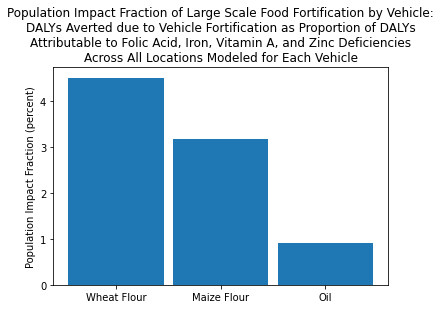

In [58]:
# GLOBAL PIF BY VEHICLE FOR ALL LOCATIONS MODELED FOR EACH VEHICLE

wheat = global_wheat_pif
maize = global_maize_pif
oil = global_oil_pif
barWidth = 0.20
spacerWidth = barWidth / 10
a = np.arange(1)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
plt.bar(a, wheat['mean'].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Wheat four')
plt.bar(b, maize['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Maize four')
plt.bar(c, oil['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Oil')
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAcross All Locations Modeled for Each Vehicle')
plt.xticks([a[0], b[0], c[0]], ['Wheat Flour','Maize Flour','Oil'])

Text(0.5, 1.0, 'Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')

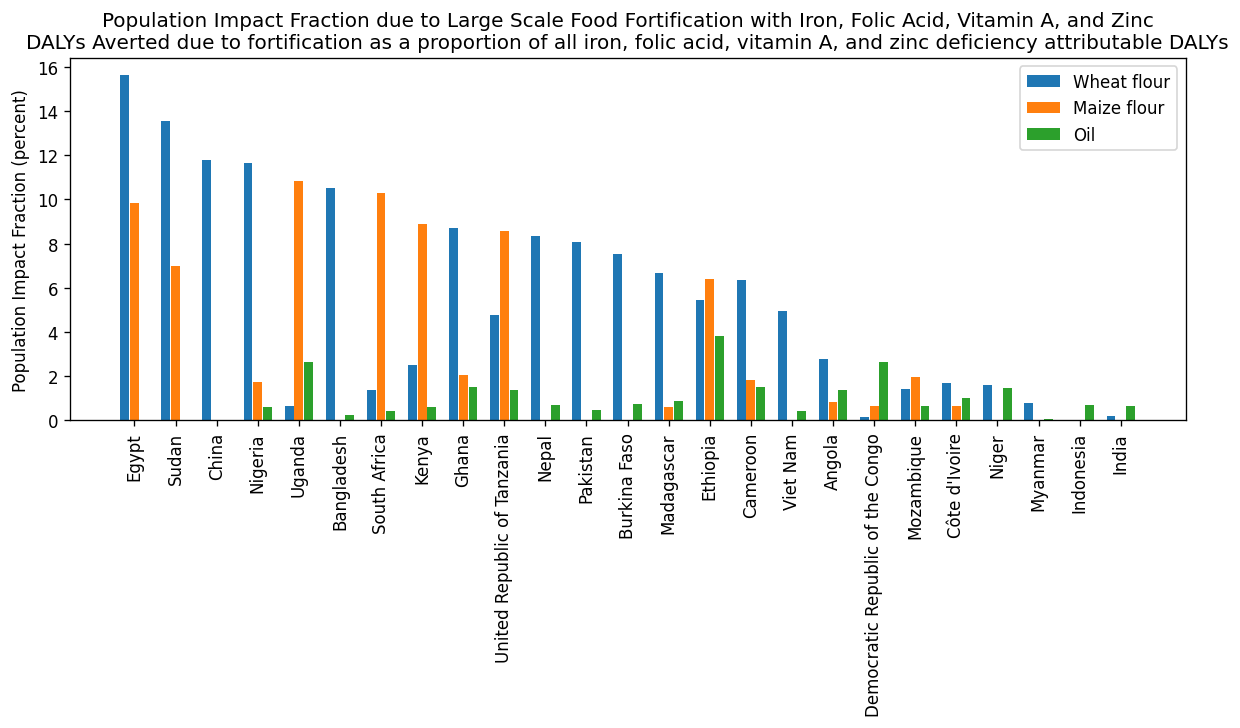

In [62]:
#LOCATION-SPECIFIC PIFS BY VEHICLE (OIL DENOMINATOR IS ALL MN DALYS)

f, ax = plt.subplots(figsize=(12, 4), dpi=120)

l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]

plot = (pif_by_location_and_vehicle
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .reset_index())

order = plot.groupby(['location_id','location_name'])['mean'].max().reset_index().sort_values(by='mean', ascending=False)
order['order'] = list(range(0,25))
order = order.drop(columns='mean')

plot = plot.merge(order, on=['location_name','location_id']).sort_values(by='order')

oil = plot.loc[plot.vehicle=='oil']
oil = order.merge(oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

maize = plot.loc[plot.vehicle=='maize flour']
maize = order.merge(maize, on=['location_id','location_name','order'], how='left').sort_values(by='order')

wheat = plot.loc[plot.vehicle=='wheat flour']
wheat = order.merge(wheat, on=['location_id','location_name','order'], how='left').sort_values(by='order')

barWidth = 0.215
spacerWidth = barWidth / 10
a = np.arange(25)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]


plt.bar(a, wheat['mean'], 
        width=barWidth, label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, label='Maize flour')
plt.bar(c, oil['mean'], 
        width=barWidth, label='Oil')

plt.legend(loc='upper right')
plt.xticks(b, oil.location_name.values, rotation=90)
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')
#plt.suptitle('DALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')


Text(0.5, 1.0, 'Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')

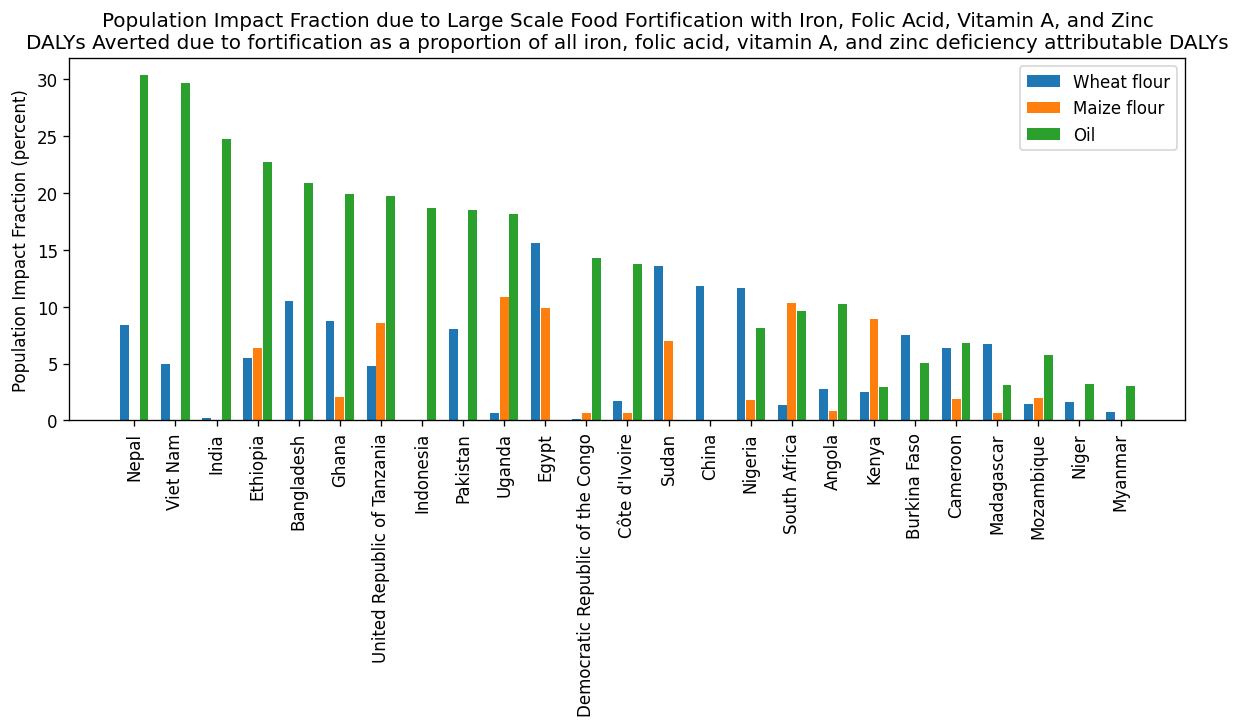

In [64]:
#LOCATION-SPECIFIC PIFS BY VEHICLE (OIL DENOMINATOR IS VITAMIN A DALYS ONLY)

f, ax = plt.subplots(figsize=(12, 4), dpi=120)

l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]

plot = (pif_by_location_and_vehicle
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .reset_index())
plot = plot.loc[plot.vehicle!='oil']

oil_plot = (results.loc[results.measure=='pif'].loc[results.coverage_level==0.8].loc[results.vehicle=='oil'])
oil_plot = oil_plot.set_index(['location_id','location_name','vehicle'])
oil_plot = (oil_plot.drop(columns=[c for c in oil_plot.columns if 'draw' not in c])
            .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .reset_index())

plot = pd.concat([plot, oil_plot], ignore_index=True)

order = plot.groupby(['location_id','location_name'])['mean'].max().reset_index().sort_values(by='mean', ascending=False)
order['order'] = list(range(0,25))
order = order.drop(columns='mean')

plot = plot.merge(order, on=['location_name','location_id']).sort_values(by='order')

oil = plot.loc[plot.vehicle=='oil']
oil = order.merge(oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

maize = plot.loc[plot.vehicle=='maize flour']
maize = order.merge(maize, on=['location_id','location_name','order'], how='left').sort_values(by='order')

wheat = plot.loc[plot.vehicle=='wheat flour']
wheat = order.merge(wheat, on=['location_id','location_name','order'], how='left').sort_values(by='order')

barWidth = 0.215
spacerWidth = barWidth / 10
a = np.arange(25)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]


plt.bar(a, wheat['mean'], 
        width=barWidth, label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, label='Maize flour')
plt.bar(c, oil['mean'], 
        width=barWidth, label='Oil')

plt.legend(loc='upper right')
plt.xticks(b, oil.location_name.values, rotation=90)
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')
#plt.suptitle('DALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')
